In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# import data

In [3]:
from emissions.data import load_data, clean_data, split

df = load_data()
df = clean_data(df)
df.head()

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 168908

Records where ODOMETER = 0: 811

Records after droping rows where ODOMETER is missing: 168013

Records after droping rows where MILE_YEAR > 40,000: 167038

61 make labels each account for less than 0.01% of cars and together account for 0.1004% of cars
Grouping these car makes into one category called 'other'

Records in output data:167038

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10247
Unique vehicles in Pass: 78825

    Final features: 
    MAKE, VEHICLE_TYPE, MAKE_VEHICLE_TYPE

,VEHICLE_TYPE,VEHICLE_AGE,MILE_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,TEST_TYPE,RESULT,MAKE,BEFORE_2000,ENGINE_WEIGHT_RATIO,SPORT,MAKE_VEHICLE_TYPE
0,3,4,3637.25,6700.0,3700,A,I,0,dodge,0,0.55,0,dodge3
1,1,13,12142.85,3125.0,2000,A,I,0,other,0,0.64,0,other1
2,1,14,12862.07,3875.0,2300,A,I,1,other,0,0.59,0,other1
3,1,19,7041.84,3625.0,3000,A,I,0,other,1,0.83,0,other1
4,1,7,16336.71,2750.0,1600,A,I,0,chevrolet,0,0.58,0,chevrolet1


# check the features first

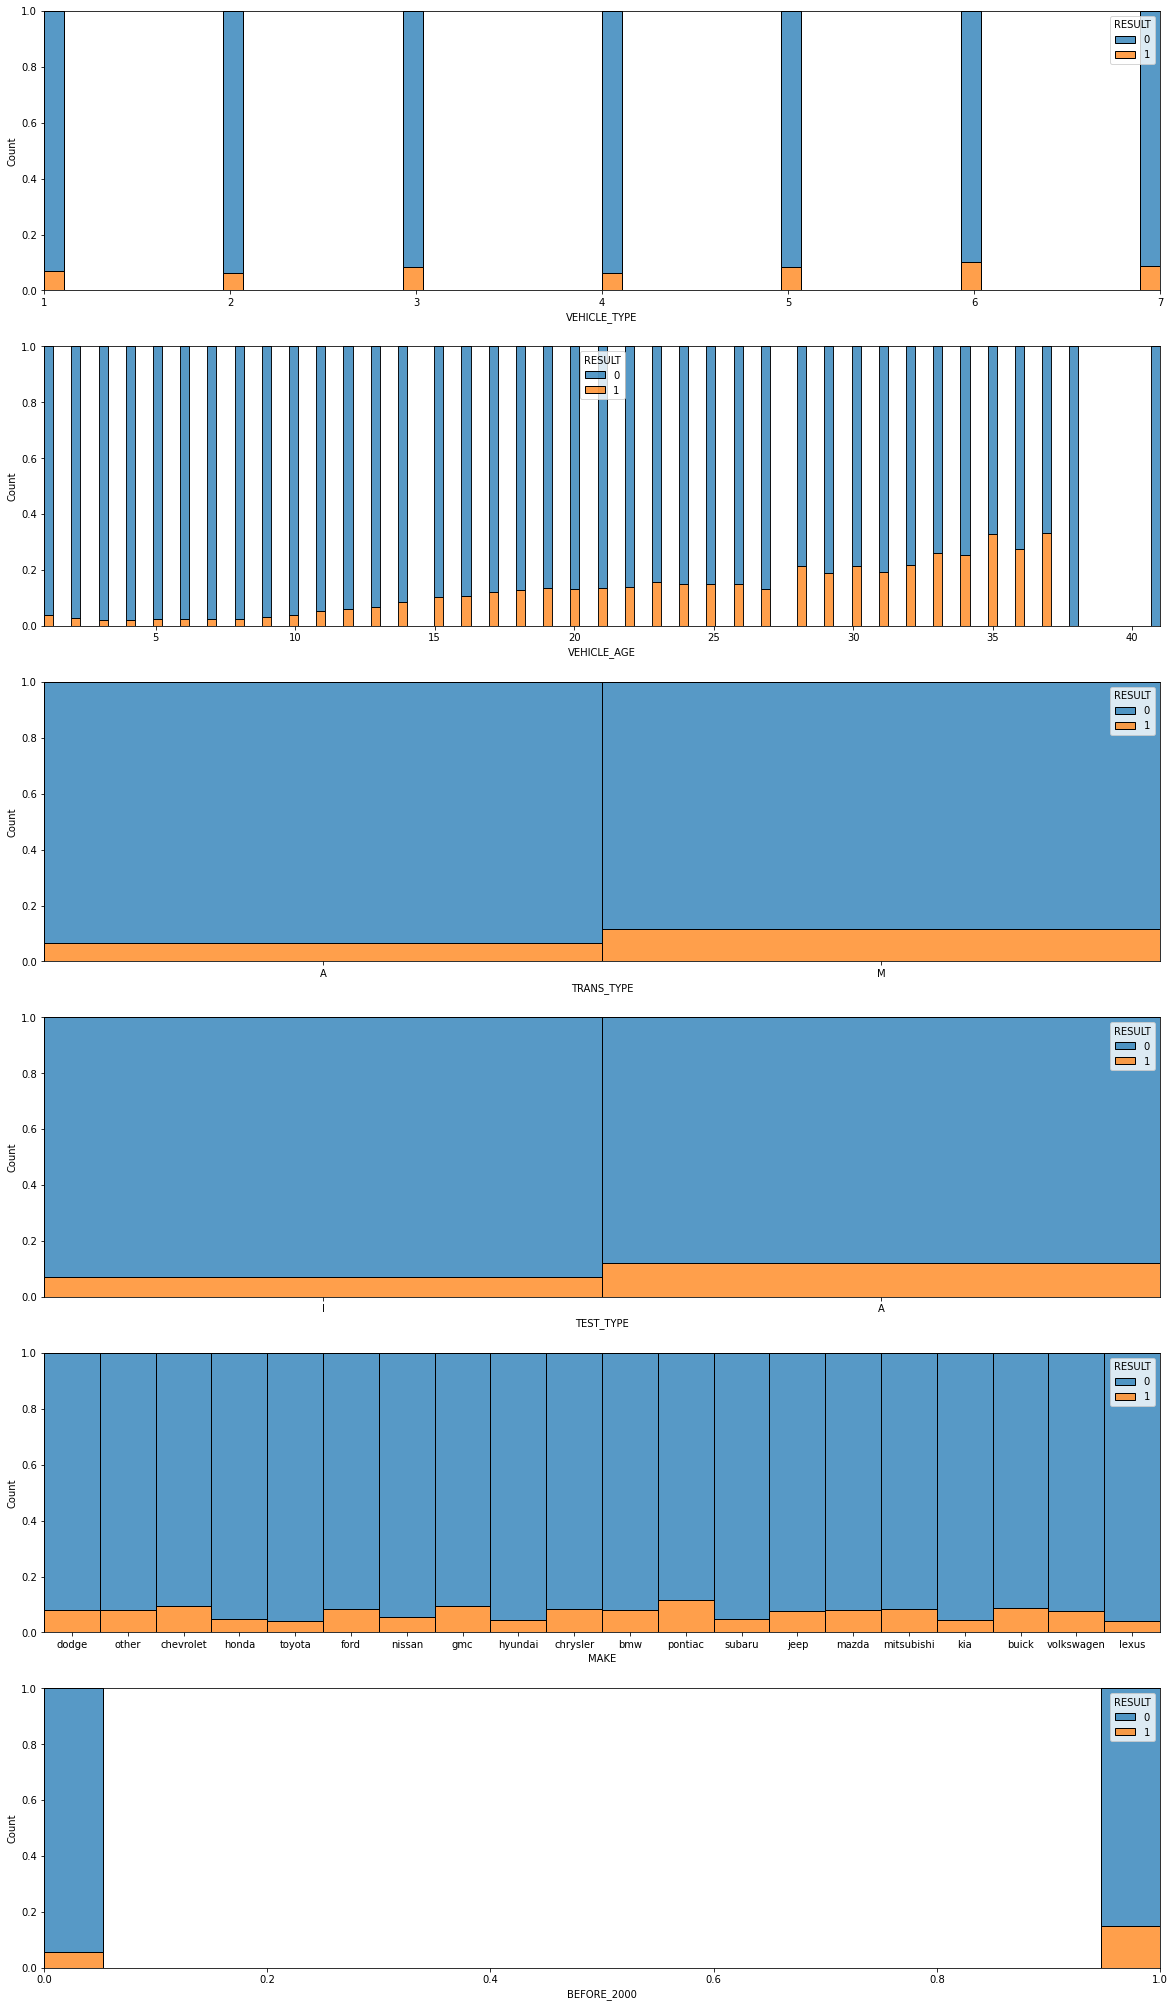

In [4]:
# categorical columns
cols = ['VEHICLE_TYPE', 'VEHICLE_AGE', 'TRANS_TYPE', 'TEST_TYPE', 'MAKE', 'BEFORE_2000']
fig, axs = plt.subplots(6, 1, figsize=(20, 36))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', multiple='fill', ax=ax)

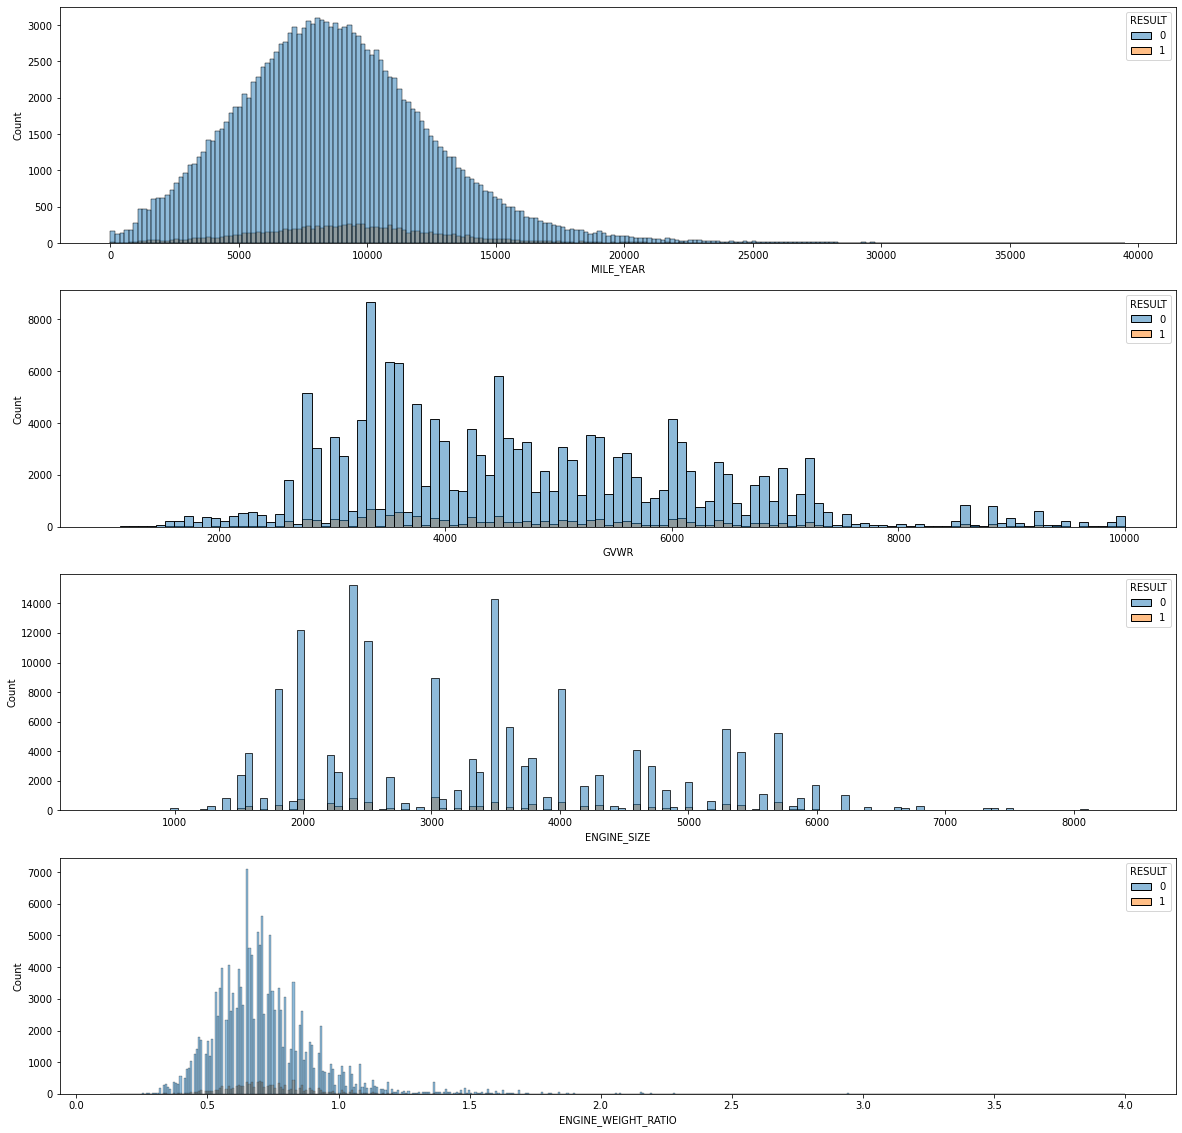

In [5]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO']
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', ax=ax)

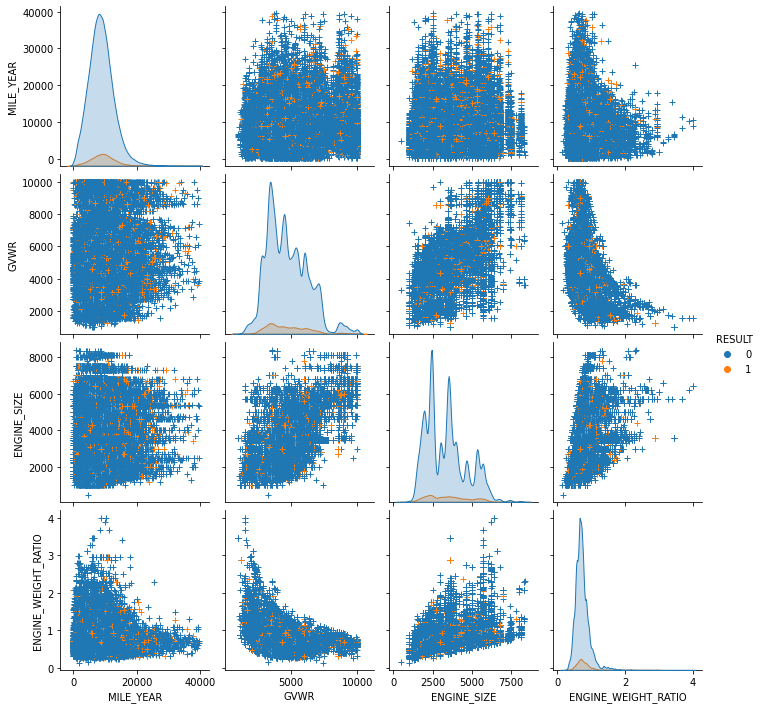

In [6]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO', 'RESULT']
sns.pairplot(data=df[cols], 
             hue='RESULT',
             plot_kws=dict(marker="+", linewidth=1, edgecolor=None));

# Train test split

In [7]:
X_train, X_test, y_train, y_test = split(df)

----------------data splitted into train test----------------
Share of Pass and Fail in train set:
Pass: 7%
Fail: 93%
Share of Pass and Fail in test set:
Pass: 7%
Fail: 93%


# Baseline model 1:  all vehicles with age > 16 will fail the test
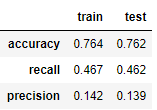

In [8]:
X_train.join(y_train).groupby('RESULT').VEHICLE_AGE.describe()

,count,mean,std,min,25%,50%,75%,max
RESULT,,,,,,,,
0,124182.0,11.871487,6.155406,1.0,7.0,11.0,16.0,41.0
1,9448.0,16.370555,6.472697,1.0,12.0,16.0,20.0,37.0


In [9]:
# train
train = {}
y_pred = (X_train.VEHICLE_AGE > 16).astype('int')
y_true = y_train
train['accuracy'] = round(accuracy_score(y_true, y_pred), 3)
train['recall'] = round(recall_score(y_true, y_pred), 3)
train['precision'] = round(precision_score(y_true, y_pred), 3)

# test
test = {}
y_pred = (X_test.VEHICLE_AGE > 16).astype('int')
y_true = y_test
test['accuracy'] = round(accuracy_score(y_true, y_pred), 3)
test['recall'] = round(recall_score(y_true, y_pred), 3)
test['precision'] = round(precision_score(y_true, y_pred), 3)

pd.DataFrame({'train':train, 'test':test})

,train,test
accuracy,0.764,0.762
recall,0.467,0.462
precision,0.142,0.139


# Baseline model 2: VEHICLE_AGE + MAKE
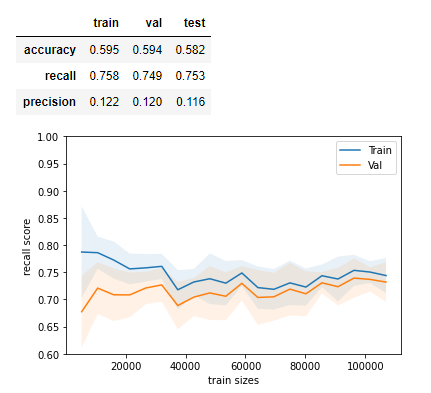

Question: 

In [71]:
cols = ['VEHICLE_AGE', 'MAKE']
X_train[cols].head()

,VEHICLE_AGE,MAKE
27899,19,other
31944,14,mazda
29361,12,honda
138648,7,jeep
51342,13,ford


## grid search


In [72]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 8}, 0.7491592682270648)

In [73]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
6,8,0.749159,0.757961
5,7,0.747572,0.755256
7,9,0.740262,0.751564
0,2,0.732432,0.733947
8,10,0.722584,0.736347


In [76]:
result = search.cv_results_
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][6], 
                       'recall': result['mean_train_recall'][6],
                       'precision': result['mean_train_precision'][6]}, 
              'val':{'accuracy': result['mean_test_accuracy'][6], 
                       'recall': result['mean_test_recall'][6],
                       'precision': result['mean_test_precision'][6]}
             })
tmp

,train,val
accuracy,0.594964,0.593669
recall,0.757961,0.749159
precision,0.121548,0.120105


## scoring on test set

In [77]:
y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp.round(3)

,train,val,test
accuracy,0.595,0.594,0.582
recall,0.758,0.749,0.753
precision,0.122,0.120,0.116


## learning curve


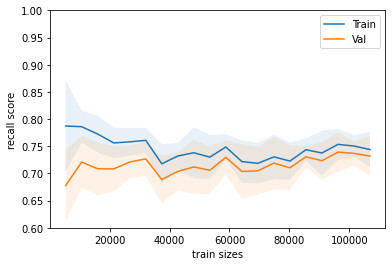

In [78]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        cv=cv,
                                                        scoring='recall',
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes')
plt.ylim(0.6, 1);

# Evaluate features


## functions

In [16]:
def scoring_table(search, param_index):
    """ takes grid search output and returns a scoring table"""
    result = search.cv_results_
    tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][param_index], 
                           'recall': result['mean_train_recall'][param_index],
                           'precision': result['mean_train_precision'][param_index]}, 
                  'val':{'accuracy': result['mean_test_accuracy'][param_index], 
                           'recall': result['mean_test_recall'][param_index],
                           'precision': result['mean_test_precision'][param_index]}
                 })

    y_pred = search.best_estimator_.predict(X_test[cols])
    y_true = y_test
    tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
    tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
    tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
    return tmp.round(3)

In [17]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, X_train, y_train):
    """takes model, X_train, y_train and plots learning curve"""

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                            X_train[cols], 
                                                            y_train, 
                                                            train_sizes=np.linspace(0.05, 1, 20),
                                                            cv=cv,
                                                            scoring='recall',
                                                            n_jobs=-1
                                                           )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Train')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1)

    plt.plot(train_sizes, test_scores_mean, label = 'Val')
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1)
    plt.legend()
    plt.ylabel('recall score')
    plt.xlabel('train sizes')
    plt.ylim(0.6, 1);

## Tree 1.1: VEHICLE_AGE + TRANS_TYPE

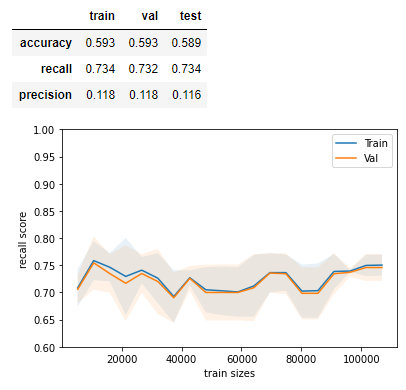


In [46]:
cols = ['VEHICLE_AGE', 'TRANS_TYPE'] 
X_train[cols].head()

,VEHICLE_AGE,TRANS_TYPE
27899,19,A
31944,14,A
29361,12,A
138648,7,A
51342,13,A


In [47]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TRANS_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [48]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
3,5,0.687977,0.687976
4,6,0.687977,0.687976
5,7,0.687977,0.687976
6,8,0.687977,0.687976


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


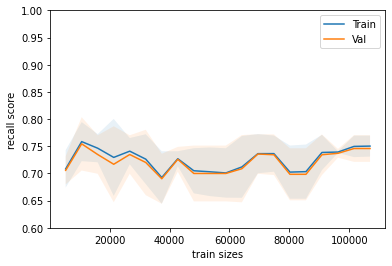

In [49]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.2: VEHICLE_AGE + MILE_YEAR
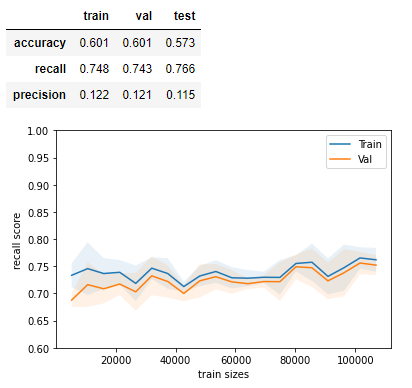

In [79]:
cols = ['VEHICLE_AGE', 'MILE_YEAR']
X_train[cols].head()

,VEHICLE_AGE,MILE_YEAR
27899,19,6234.95
31944,14,11399.21
29361,12,9055.67
138648,7,12125.00
51342,13,9936.46


In [81]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 4}, 0.7425927046901623)

In [83]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_max_depth,mean_test_recall,mean_train_recall
2,4,0.742593,0.747907
0,2,0.732432,0.733947
3,5,0.716134,0.723633
5,7,0.700254,0.718694
4,6,0.689878,0.702783


,train,val,test
accuracy,0.601,0.601,0.573
recall,0.748,0.743,0.766
precision,0.122,0.121,0.115


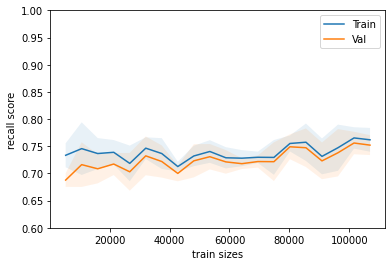

In [84]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 2)

## Tree 1.3: VEHICLE_AGE + VEHICLE_TYPE
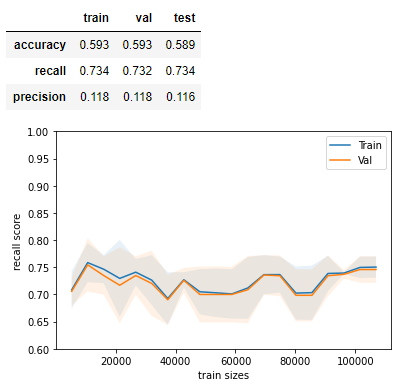

In [54]:
cols = ['VEHICLE_AGE', 'VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,VEHICLE_TYPE
27899,19,1
31944,14,1
29361,12,4
138648,7,4
51342,13,3


In [30]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [28]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.726082,0.728831
3,5,0.714967,0.717189
4,6,0.714755,0.718300
2,4,0.714121,0.717744
8,10,0.713697,0.719517


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


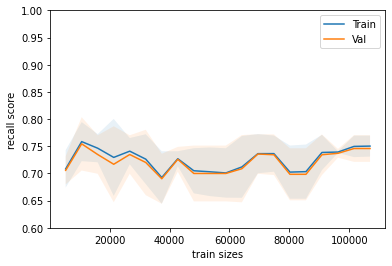

In [31]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.4: VEHICLE_AGE + MAKE_VEHICLE_TYPE

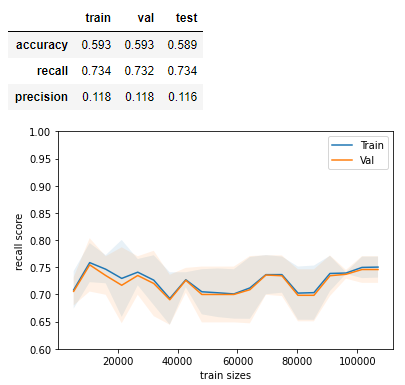


In [55]:
cols = ['VEHICLE_AGE', 'MAKE_VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,MAKE_VEHICLE_TYPE
27899,19,other1
31944,14,mazda1
29361,12,honda4
138648,7,jeep4
51342,13,ford3


In [56]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE_VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 18, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [58]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
3,5,0.715814,0.719164
13,15,0.712845,0.736265
14,16,0.710728,0.736594
1,3,0.708515,0.712202


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


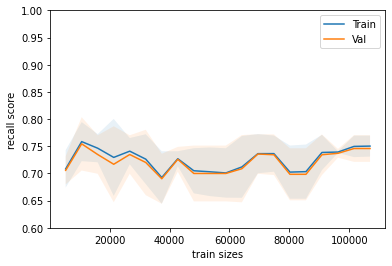

In [59]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.5: VEHICLE_AGE + ENGINE_WEIGHT_RATIO

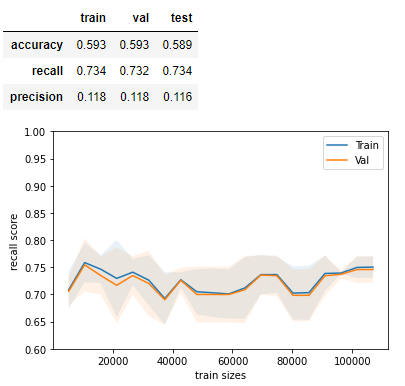


In [38]:
cols = ['VEHICLE_AGE', 'ENGINE_WEIGHT_RATIO']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_WEIGHT_RATIO
27899,19,1.19
31944,14,0.67
29361,12,0.74
138648,7,0.98
51342,13,0.94


In [39]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 2}, 0.7324321809703166)

In [40]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()


,param_max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
4,6,0.703536,0.709462
6,8,0.702266,0.719906
5,7,0.700891,0.710121
2,4,0.699726,0.700689


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


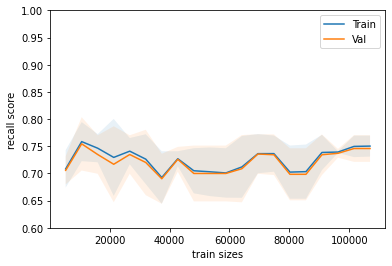

In [42]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.6: VEHICLE_AGE + ENGINE_SIZE

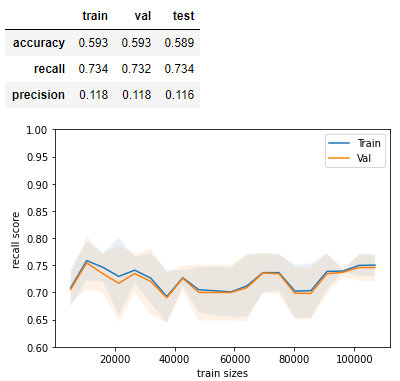


In [60]:
cols = ['VEHICLE_AGE', 'ENGINE_SIZE']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_SIZE
27899,19,4600
31944,14,2000
29361,12,3500
138648,7,6400
51342,13,4000


In [62]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 2}, 0.7324321809703166)

In [63]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
5,7,0.711578,0.722752
4,6,0.711054,0.717212
6,8,0.709567,0.727268
3,5,0.705651,0.714084


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


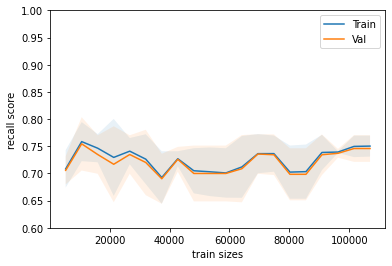

In [65]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.7: VEHICLE_AGE + TEST_TYPE

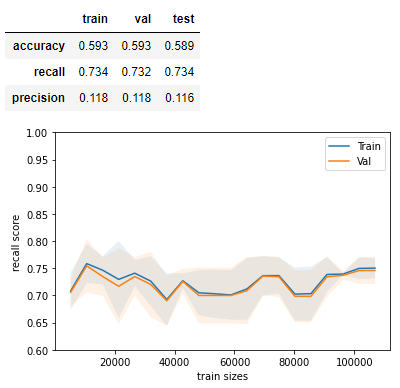


In [66]:
cols = ['VEHICLE_AGE', 'TEST_TYPE']
X_train[cols].head()

,VEHICLE_AGE,TEST_TYPE
27899,19,I
31944,14,I
29361,12,I
138648,7,I
51342,13,I


In [68]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TEST_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [69]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
1,3,0.684167,0.684166
2,4,0.684061,0.684531
3,5,0.683744,0.684778
4,6,0.683532,0.684848


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


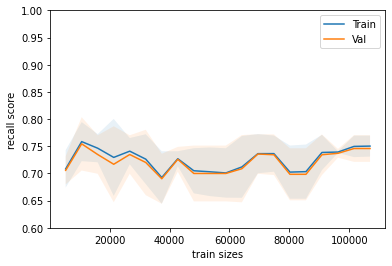

In [70]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

# Tree 2 : VEHICLE_AGE + MILE_YEAR + MAKE  ?
# Forest : VEHICLE_AGE + MILE_YEAR + MAKE  ?

In [86]:
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE']
X_train[cols].head()

,VEHICLE_AGE,MILE_YEAR,MAKE
27899,19,6234.95,other
31944,14,11399.21,mazda
29361,12,9055.67,honda
138648,7,12125.00,jeep
51342,13,9936.46,ford


In [94]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(8, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 9}, 0.7087243296565331)

In [95]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()


,param_model__max_depth,mean_test_recall,mean_train_recall
1,9,0.708724,0.755739
0,8,0.707768,0.739722
2,10,0.701418,0.766900
3,11,0.682688,0.768981
4,12,0.671680,0.784563


,train,val,test
accuracy,0.646,0.639,0.656
recall,0.756,0.709,0.686
precision,0.137,0.128,0.130


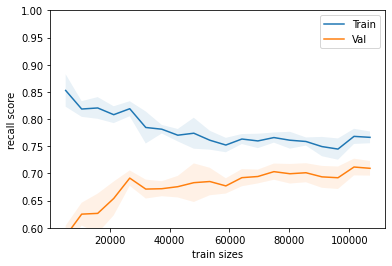

In [96]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 1)